In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

from google.colab import files

uploaded = files.upload()

Saving tabla_adulto_equiv.xlsx to tabla_adulto_equiv.xlsx
Saving usu_hogar_T123.xlsx to usu_hogar_T123.xlsx
Saving usu_individual_T123.xlsx to usu_individual_T123.xlsx


1. Exploren el disen ̃o de registro de la base de hogar: a priori, ¿qu ́e variables creen que pueden ser muy predictivas de pobreza y que ser ́ıa muy u ́til incluir para perfeccionar el ejercicio del TP2?


In [ ]:
# VARIABLES QUE ME INTERESAN
# IV1 (tipo de alojamiento)
# IV6 (disponilidad de agua)
# IV12_1 (La vivienda está ubicada cerda de basural (3 cuadras o menos))
#II9 (Acceso de un Baño, propio baño, compartido con otras, etc))
# V5 (si han vivido de algún subsidio o ayuda social (de gobierno, iglesia, etc))
#CH09 - Sabe leer y escribir
#Nivel_ED - Nivel de educacción

#Quedar con todos excepto que columnas que no tienen ningun sentido
# (años, codigos que no son relevantes, saca ingresos)

2. Descarguen la base de microdatos de la EPH correspondiente al primer trimestre de 2023 (la base de hogares se llama usu hogar T123.xls). Importen los datos de la encuesta de hogar y, al igual que en el TP2, conserven so ́lo las observaciones que corresponden a los aglomerados de Ciudad Auto ́noma de Buenos Aires o del Gran Buenos Aires.

In [2]:
import pandas as pd


file_names = list(uploaded.keys())

# Create separate DataFrames for each uploaded file
# You can specify different variable names (df1, df2, df3, etc.) based on the number of uploaded files
df1 = pd.read_excel(file_names[0],  skiprows = 4, header=0) #adul_equiv
df2 = pd.read_excel(file_names[1])                    # df de hogar
df3 = pd.read_excel(file_names[2])                    # df de individuo


def filter_region(df):  # hice un funcción para reducir el numero de lineas


    gran_buenos_aires = 1 # se declara un variable que es igual de 1 - la numera que corresponde a gente que vive en Buenos Aires
    region_filtered = df['REGION'] == gran_buenos_aires

    df = df[region_filtered] #nueva dataframe, que es actualizado en respecto con el filtro de region
    return df

df2 = filter_region(df2)
df3 = filter_region(df3)



3. Unan la tabla de la encuesta individual con la de la encuesta de hogar.


In [3]:
# baja columnas que faltan valores numericos, o que no son relevantes

df2 = df2.drop(columns = ['ANO4', 'TRIMESTRE', 'DECIFR', 'IDECIFR', 'RDECIFR', 'GDECIFR', 'PDECIFR', 'ADECIFR',
                    'DECCFR', 'IDECCFR','IPCF', 'RDECCFR', 'GDECCFR', 'PDECCFR', 'ADECCFR', 'MAS_500',
                          'REALIZADA', 'IV1_ESP', 'IV3_ESP', 'IV7_ESP', 'II7_ESP', 'II8_ESP'])
df3 = df3.drop(columns= ['ITF', 'DECIFR', 'IDECIFR', 'RDECIFR', 'GDECIFR', 'PDECIFR', 'ADECIFR',
                    'DECCFR', 'IDECCFR','IPCF', 'RDECCFR', 'GDECCFR', 'PDECCFR', 'ADECCFR', 'PONDIH','ANO4', 'TRIMESTRE', 'MAS_500'])
# creo que tiene mas sentido para hacer el drop antes del merge
merged_df = pd.merge(df2, df3, on=['CODUSU', 'NRO_HOGAR'])

merged_df = merged_df.drop_duplicates()
print(merged_df['CODUSU'])

0       TQRMNORVYHMOTSCDEIJAH00802517
1       TQRMNORVYHMOTSCDEIJAH00802517
2       TQRMNOSQRHLLTTCDEIJAH00719390
3       TQRMNOSQRHLLTTCDEIJAH00719390
4       TQSMNOSQRHLLTTCDEIJAH00719389
                    ...              
7614    TQRMNOSSQHKOOMCDEIJAH00802644
7615    TQRMNOSSQHKOOMCDEIJAH00802644
7616    TQRMNOSSQHKOOMCDEIJAH00802644
7617    TQRMNORYPHJKNPCDEIJAH00794297
7618    TQRMNORYPHJKNPCDEIJAH00794297
Name: CODUSU, Length: 7619, dtype: object


4. Generen sus propias funciones para limpiar la base de datos o, si deciden utilizar funciones existentes en paquetes como numpy y pandas, mencionen cu ́ales usar ́an y de qu ́e paquetes son.

In [4]:
def calc_nonoutlier_range(series):
	Q3 = series.quantile(0.75)
	Q1 = series.quantile(0.25)
	IQR = Q3 - Q1
	lower_value = Q1 - 1.5 * IQR
	upper_value = Q3 + 1.5 * IQR
	return [lower_value, upper_value]


itf = merged_df['ITF'] # eliminacción de algunos outliers

rango = calc_nonoutlier_range(itf)

filt_remove_outliers = (itf >= rango[0]) & (itf <= rango[1])

merged_df = merged_df[filt_remove_outliers]

merged_df = merged_df.dropna(axis=1, how='any') # Solo bajé columnas si todos de sus valores son nAn

merged_df = merged_df.T.drop_duplicates().T




5. Limpien la base de datos tomando criterios que hagan sentido, tanto para el tratamiento de valores faltantes, de outliers, como as ́ı tambi ́en decidan qu ́e va- riables catego ́ricas y strings usar ́an y transfo ́rmenlas de forma que haga sentido para los ejercicios siguientes. Justifiquen sus decisiones.

ya limpié por arriba, porque me parecía mas facil para hacer antes del merge.

6. Presenten estad ́ısticas descriptivas de cinco variables de la encuesta de hogar que ustedes creen que pueden ser relevantes para predecir pobreza.

In [5]:
def desc_estadisticas(columna):
	# Calculate the mean
	medio = columna.mean()
	# Calculate the median
	mediana = columna.median()
	# Calculate frequency counts
	cuentas_frequencia = columna.value_counts()
	# Print the results
	return "Medio: ", medio, " Mediana: ", mediana, " cuentas de frequencia: ", cuentas_frequencia




7. Repitan el inciso 1.2.f del TP2 para construir la columna adulto equiv y la columna ad equiv hogar (pueden utilizar su co ́digo del TP2).


In [8]:
import numpy as np



df1.columns = ['CH06', 'Mujeres', 'Varones']
df1['CH06'] = df1['CH06'].str.replace(r'\D', '', regex=True) # evitando valores 'strings' de la columna con años
merged_df['CH06'] = merged_df['CH06'].astype(int) # asegurar que los valos se reconoce como numeric

conditions_varones = [
    (merged_df['CH06'] == 0) & (merged_df['CH04'] == 1),
    (merged_df['CH06'] == 1) & (merged_df['CH04'] == 1),
    (merged_df['CH06'] == 2) & (merged_df['CH04'] == 1),
    (merged_df['CH06'] == 3) & (merged_df['CH04'] == 1),
    (merged_df['CH06'] == 4) & (merged_df['CH04'] == 1),
    (merged_df['CH06'] == 5) & (merged_df['CH04'] == 1),
    (merged_df['CH06'] == 6) & (merged_df['CH04'] == 1),
    (merged_df['CH06'] == 7) & (merged_df['CH04'] == 1),
    (merged_df['CH06'] == 8) & (merged_df['CH04'] == 1),
    (merged_df['CH06'] == 9) & (merged_df['CH04'] == 1),
    (merged_df['CH06'] == 10) & (merged_df['CH04'] == 1),
    (merged_df['CH06'] == 11) & (merged_df['CH04'] == 1),
    (merged_df['CH06'] == 12) & (merged_df['CH04'] == 1),
    (merged_df['CH06'] == 13) & (merged_df['CH04'] == 1),
    (merged_df['CH06'] == 14) & (merged_df['CH04'] == 1),
    (merged_df['CH06'] == 15) & (merged_df['CH04'] == 1),
    (merged_df['CH06'] == 16) & (merged_df['CH04'] == 1),
    (merged_df['CH06'] == 17) & (merged_df['CH04'] == 1),
    ((merged_df['CH06'] >= 18) & (merged_df['CH06'] <= 29) & (merged_df['CH04'] == 1)),
    ((merged_df['CH06'] >= 30) & (merged_df['CH06'] <= 45) & (merged_df['CH04'] == 1)),
    ((merged_df['CH06'] >= 46) & (merged_df['CH06'] <= 60) & (merged_df['CH04'] == 1)),
    ((merged_df['CH06'] >= 61) & (merged_df['CH06'] <= 75) & (merged_df['CH04'] == 1)),
    (merged_df['CH06'] > 75) & (merged_df['CH04'] == 1),
] # classificación de valores según de edad y genero

conditions_mujeres = [
    (merged_df['CH06'] == 0) & (merged_df['CH04'] == 2),
    (merged_df['CH06'] == 1) & (merged_df['CH04'] == 2),
    (merged_df['CH06'] == 2) & (merged_df['CH04'] == 2),
    (merged_df['CH06'] == 3) & (merged_df['CH04'] == 2),
    (merged_df['CH06'] == 4) & (merged_df['CH04'] == 2),
    (merged_df['CH06'] == 5) & (merged_df['CH04'] == 2),
    (merged_df['CH06'] == 6) & (merged_df['CH04'] == 2),
    (merged_df['CH06'] == 7) & (merged_df['CH04'] == 2),
    (merged_df['CH06'] == 8) & (merged_df['CH04'] == 2),
    (merged_df['CH06'] == 9) & (merged_df['CH04'] == 2),
    (merged_df['CH06'] == 10) & (merged_df['CH04'] == 2),
    (merged_df['CH06'] == 11) & (merged_df['CH04'] == 2),
    (merged_df['CH06'] == 12) & (merged_df['CH04'] == 2),
    (merged_df['CH06'] == 13) & (merged_df['CH04'] == 2),
    (merged_df['CH06'] == 14) & (merged_df['CH04'] == 2),
    (merged_df['CH06'] == 15) & (merged_df['CH04'] == 2),
    (merged_df['CH06'] == 16) & (merged_df['CH04'] == 2),
    (merged_df['CH06'] == 17) & (merged_df['CH04'] == 2),
    ((merged_df['CH06'] >= 18) & (merged_df['CH06'] <= 29) & (merged_df['CH04'] == 2)),
    ((merged_df['CH06'] >= 30) & (merged_df['CH06'] <= 45) & (merged_df['CH04'] == 2)),
    ((merged_df['CH06'] >= 46) & (merged_df['CH06'] <= 60) & (merged_df['CH04'] == 2)),
    ((merged_df['CH06'] >= 61) & (merged_df['CH06'] <= 75) & (merged_df['CH04'] == 2)),
    (merged_df['CH06'] > 75) & (merged_df['CH04'] == 2)]


default_choice = 0.0

choices_varones = [
    0.35, 0.37, 0.46, 0.51, 0.55, 0.60, 0.64, 0.66, 0.68, 0.69, 0.79,
    0.82, 0.85, 0.90, 0.96, 1.00, 1.03, 1.04, 1.02, 1.00, 1.00, 0.83, 0.74
]

choices_mujeres = [
    0.35, 0.37, 0.46, 0.51, 0.55, 0.60, 0.64, 0.66, 0.68, 0.69, 0.70,
    0.72, 0.74, 0.76, 0.76, 0.77, 0.77, 0.77, 0.76, 0.77, 0.76, 0.67, 0.63
]

merged_df['adulto_equiv'] = np.select(conditions_varones, choices_varones) + np.select(conditions_mujeres, choices_mujeres, default_choice)


8. Repitan el inciso 1.3 y 1.4 del TP2 para dividir la base en dos dataframes donde: uno conserve las personas que no reportaron ITF (dataframe llamado
2
respondieron) y otro conserve a las personas que no reportaron ITF (llama- do norespondieron). Adem ́as, agreguen a la base respondieron una colum- na llamada ingreso necesario que sea el producto de la canasta b ́asica por ad equiv hogar.


In [9]:
print(merged_df['CODUSU'])
print(merged_df.shape)


0       TQRMNORVYHMOTSCDEIJAH00802517
1       TQRMNORVYHMOTSCDEIJAH00802517
2       TQRMNOSQRHLLTTCDEIJAH00719390
3       TQRMNOSQRHLLTTCDEIJAH00719390
4       TQSMNOSQRHLLTTCDEIJAH00719389
                    ...              
7614    TQRMNOSSQHKOOMCDEIJAH00802644
7615    TQRMNOSSQHKOOMCDEIJAH00802644
7616    TQRMNOSSQHKOOMCDEIJAH00802644
7617    TQRMNORYPHJKNPCDEIJAH00794297
7618    TQRMNORYPHJKNPCDEIJAH00794297
Name: CODUSU, Length: 7293, dtype: object
(7293, 120)


In [10]:
ad_equiv_hogar1 = merged_df.groupby('CODUSU')['adulto_equiv'].sum().reset_index()

merged_df = merged_df.merge(ad_equiv_hogar1, on='CODUSU', how='left')

merged_df.rename(columns={'adulto_equiv_y': 'ad_equiv_hogar1'}, inplace=True)
merged_df.rename(columns={'adulto_equiv_x': 'adulto_equiv'}, inplace=True) # se renombra las columnas

#print(merged_df)

canasta = 57371.05 # se declara canasta

#drop duplicates, (CODUSU) para quedarme con un individuo por hogar

merged_df = merged_df.drop_duplicates(subset=['CODUSU'])
merged_df = merged_df.drop(columns = ['CODUSU', 'NRO_HOGAR'])



9. Agreguen a la base respondieron una columna llamada pobre, que tome valor 1 si el ITF es menor al ingreso necesario que necesita esa familia y 0 en caso contrario.

In [72]:
respondieron = merged_df[merged_df['ITF'] != 0].copy()
respondieron['ingreso_necesario'] = respondieron['ad_equiv_hogar1'] * canasta
respondieron['pobre'] = (respondieron['ITF'] < respondieron['ingreso_necesario']).astype(int) # se declara la columna pobreza




10. En el TP2 calcularon los individuos bajo la l ́ınea de pobreza. Sin embargo, cuando se habla de pobreza el nu ́mero ma ́s utilizado es el de la tasa de hogares bajo la l ́ınea de pobreza. Para calcularlo, utilicen una sola observaci ́on por hogar y sumen el ponderador PONDIH que permite expandir la muestra de la EPH al total de la poblacio ́n que representa. ¿Cu ́al es la tasa de hogares bajo la l ́ınea de pobreza para el GBA? ¿Se asemeja al que reporta el INDEC en sus informes?

In [73]:
tasa = respondieron.groupby('pobre')['PONDIH'].sum().reset_index()


sum = tasa['PONDIH'].sum()

# Calculate the proportion for each value in 'PONDIH_x'
tasa['proporcion'] = tasa['PONDIH'] / sum
print(tasa)

# la proporción de hogares bajo de la linea de pobreza en GBA es 29.6%, tan cerca de lo que tenemos.


   pobre   PONDIH proporcion
0      0  3368306   0.691298
1      1  1504129   0.308702


In [74]:
# baja columnas si no se pueden convertir en columnas numericos

for column in respondieron.columns:
    try:
        respondieron[column] = pd.to_numeric(respondieron[column])
    except TypeError:
        respondieron = respondieron.drop([column], axis=1)
    except ValueError:
        respondieron = respondieron.drop([column], axis=1)



PARTE II:

# New Section


El objetivo de esta parte del trabajo es generar co ́digo que sea flexible y que est ́e mo- dularizado (en funciones bien documentadas con docstrings). De esta forma, evitara ́n repetir co ́digo y podra ́n utilizarlo en distintos escenarios (como por ejemplo la Parte III de este TP y sus proyectos personales a futuro).

Escriban una funcio ́n, llamada evalua metodo, que reciba como argumentos un modelo y los datos de entrenamiento y prueba (X train, y train, X test, y test). La funcio ́n debe ajustar el modelo con los datos de entrenamiento y calcular las m ́etricas que considere necesarias para esta problema ́tica (de m ́ıni- ma, deben reportar la matriz de confusio ́n, las curvas ROC y los valores de AUC y de accuracy score de cada m ́etodo). El output de la funcio ́n debe ser una colecci ́on con las m ́etricas evaluadas.

In [68]:
# se llama con parametros del modelo
"""""Argumentos: Modelo, x_train, y_train, x_test, y_test
    Con estos argumentos, fit el modelo, y evalua la precicion, usando differentes medidas
        Return: metricas"""

def evalua_metodo(modelo, x_train, y_train, x_test, y_test):
    modelo.fit(x_train, y_train)
    # Predicción
    y_pred = modelo.predict(x_test)
    # Matriz de Confusion
    conf_matrix = confusion_matrix(y_test, y_pred)

    # ROC y AUC
    y_probs = modelo.predict_proba(x_test)[:, 1]  # For binary classification
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc_score = roc_auc_score(y_test, y_probs)

    # Precisión
    accuracy = accuracy_score(y_test, y_pred)

    # Diccionario para guardar las metricas
    metricas = {
        'Confusion_Matrix': conf_matrix,
        'ROC_Curve': (fpr, tpr),
        'AUC_Score': auc_score,
        'Accuracy_Score': accuracy
    }

    return metricas

2. Escriban una funcio ́n, llamada cross validation, que realice validaci ́on cru- zada con k iteraciones (k-fold CV), llamando a la funcio ́n del inciso anterior en cada una, pero para las k distintas particiones. La funci ́on debe recibir como argumentos el modelo, el valor de k y un dataset (es decir, s ́olo X e y). Pueden ayudarse con la funcio ́n KFold para generar las particiones necesarias.

In [52]:
"""""Argumentos: Modelo, modelo, X (vector de rascos), y (feature vector) X (target vector), k (numero de folds)
    Hace k-fold validacion, y evalua mse por cada division de los datos
    Return: Un base de datos con varios mse punctuaciones"""

from sklearn.preprocessing import StandardScaler

def cross_validation(modelo, X, y, k):

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    results = []

    for (train_index, test_index) in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        sc = StandardScaler()
        sc.fit(X_train)
        X_train_nuevo = sc.transform(X_train)
        X_test_nuevo = sc.transform(X_test)

        metrics = evalua_metodo(modelo, X_train, y_train, X_test, y_test)
        results.append(metrics)

        y_pred = modelo.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        metrics['MSE'] = mse



    metrics_df = pd.DataFrame(results)

    avg_mse = metrics_df['MSE'].mean()

    return avg_mse


 Escriban una funcio ́n, llamada evalua config que reciba una lista de con- figuraciones de hiperpar ́ametros1 (los distintos valores a probar como hiper- para ́metros podrian codificarse en diccionarios de Python) y utilizando la fun- cio ́n cross validation obtenga el error2 promedio para cada configuraci ́on. Finalmente, la funci ́on debe devolver la configuraci ́on que genere menor error3.

In [69]:
""""Argumentos: Modelo, hyperparam (diccionario de hyperparemetros), X, y, k (ya definé arriba)
    Si tenemos una instancia de logreg, hacemos GridSearch para encontrar el mejor valor de lambda, en otros casos, evaluamos differentes configuariones
    para determinar cuál es el mejor
    return mejor_config (el mejor configuracion)"""""

def evalua_config(X, y, k=5):
    lowest_mse = float('inf')
    mejor_config = None

    alphas = [0.001, 0.01, 0.1, 1, 10, 100]
    penalidades = ['l1', 'l2']
    for i in alphas:
      for pen in penalidades:
          lr = LogisticRegression(penalty=pen, C=1/i, solver='liblinear')
          mse = cross_validation(lr, X, y, k)
          mse_medio = mse.mean()
          if mse_medio < lowest_mse:
            lowest_mse = mse
            mejor_config = {"penalidad": pen, "alpha": i}
    print(mejor_config["penalidad"])
    print(mse)
    return mejor_config

4. Escriban una funci ́on llamada evalua multiples metodos que les permita im- plementar los siguiente m ́etodos con los hiperpara ́metros que ustedes elijan. Para la regresio ́n log ́ıstica, asegu ́rense de que esta funci ́on utilice su funcio ́n evalua config para optimizar el λ de la regularizacio ́n. Finalmente, el output de la funci ́on debe ser una tabla donde las columnas sean las m ́etricas que hayan evaluado (las que hayan incluido en la funci ́on evalua metodo) y las filas sean los modelos (con su configuracio ́n de hiperpara ́metros asociada) que hayan co- rrido. Asegu ́rense de que la tabla incluya una columna con nombre del modelo y el valor de los hiperpar ́ametros/configuraci ́on

In [70]:
""""Argumentos: modelo, hyperparametros, X, y -
    return base de datos con medidas del redimiento de los tres alroitmos.
        """""

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def evalua_multiples_metodos(X, y, hyperparametros=None):

    resultados = []
    print(X.shape, y.shape)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    knn = KNeighborsClassifier(**hyperparametros) if hyperparametros else KNeighborsClassifier()

    metricas_knn = evalua_metodo(knn, x_train, y_train, x_test, y_test)

    resultados.append({'Modelo': 'KNN', **metricas_knn})
    # Regression Logistica
    mejor_config = evalua_config(X, y, k=5)
    lr = LogisticRegression(penalty=mejor_config["penalidad"], C=1/mejor_config["alpha"], solver='liblinear')
    metricas_lr = evalua_metodo(lr, x_train, y_train, x_test, y_test)
    resultados.append({'Modelo': f'Logistic Regression - Penalidad: {mejor_config["penalidad"]}', **metricas_lr})

 # valores (me parece repetitivo, porque puse la misma linea en evalua (config)

    lda = LinearDiscriminantAnalysis()
    metricas_lda = evalua_metodo(lda, x_train, y_train, x_test, y_test)
    resultados.append({'Modelo': 'LDA', **metricas_lda})
 # evaluamos el metodo, usando el mejor config

    # el diccionario se convierte en un base de datos
   # nombre del modelo en uso
    df_metricas = pd.DataFrame(resultados)
    return df_metricas

PARTE III

1. Eliminen de ambas bases (respondieron, norespondieron) todas las variables relacionadas a ingresos (en el archivo Disen ̃o de bases y estructura ver las ca- tegor ́ıas: ingresos de la ocupacio ́n principal de los asalariados, ingresos de la ocupacio ́n principal, ingresos de otras ocupaciones, ingreso total individual, in- gresos no laborales, ingreso total familiar, ingreso per ca ́pita familiar). Eliminen tambi ́en las columnas adulto equiv, ad equiv hogar e ingreso necesario. Establezcan a la variable pobre como su variable dependiente (vector y). El resto de las variables sera ́n las variables independientes (matriz X). Dependien- do de la funci ́on que usen, no se olviden de agregar la columna de 1 cuando sea necesario.


In [ ]:
# PARTE III

    # Ya eliminé datos relacionados con ingresos antes de el merge, porque creía que era mas facil para hacerlo antes


In [75]:
respondieron = respondieron.drop(columns= ['adulto_equiv', 'ad_equiv_hogar1', 'ingreso_necesario'])
respondieron = respondieron.dropna()
y = respondieron['pobre']
X = respondieron.drop(columns = 'pobre')
X = respondieron[['IV1', 'IV6', 'IV12_1', 'II9', 'V5', 'CH09', 'NIVEL_ED']]

# IV1 (tipo de alojamiento)
# IV6 (disponilidad de agua)
# IV12_1 (La vivienda está ubicada cerda de basural (3 cuadras o menos))
#II9 (Acceso de un Baño, propio baño, compartido con otras, etc))
# V5 (si han vivido de algún subsidio o ayuda social (de gobierno, iglesia, etc))
#CH09 - Sabe leer y escribir
#Nivel_ED - Nivel de educacción
X = X.copy()
X['intercept'] = 1
# declarar una columna con valores del intercept, cuando sea necessario
print(X.shape) # quería comfirmar con las formas estaban en orden para correr al algoritmo
print(y.shape)

(1495, 8)
(1495,)



2. Corran la funcio ́n evalua multiples metodos con la base respondieron. En los pro ́ximos incisos profundizaremos en la tarea de regularizacio ́n, pero en este ejercicio prueben al menos un hiperpara ́metro para regularizar y al menos un valor de λ.

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# llama metodo


evalua_multiples_metodos(X, y)


(1495, 8) (1495,)
l1
0.27357859531772577


,Modelo,Confusion_Matrix,ROC_Curve,AUC_Score,Accuracy_Score
0,KNN,"[[185, 29], [48, 37]]","([0.0, 0.009345794392523364, 0.023364485981308...",0.700797,0.742475
1,Logistic Regression - Penalidad: l1,"[[205, 9], [50, 35]]","([0.0, 0.0, 0.004672897196261682, 0.0046728971...",0.779687,0.802676
2,LDA,"[[206, 8], [50, 35]]","([0.0, 0.0, 0.004672897196261682, 0.0046728971...",0.784524,0.806020


3. Expliquen co ́mo elegir ́ıan λ por validacio ́n cruzada. Detallen por qu ́e no usar ́ıan el conjunto de prueba (test) para su eleccio ́n.

Eligimos λ mediante de validación cruzada (lo que hicimos en el función cross_validation), pero no usaríamos el prueba de test por el proceso de optimización, porque eso resultaría en rendimiento sesgada, porque estaríamos usando datos ocultados de el modelo. Adémas, es posible que con el conjunto de prueba de test, el modelo funcionaría bien en relacion col los datos de test, pero peor con los datos de etranamiento.

4. En validacio ́n cruzada, ¿cu ́al es el problema de usar un k muy pequen ̃o y uno muy grande? Cuando k = n (con n el nu ́mero de muestras), ¿cu ́antas veces se estima el modelo?

Aunque un valor de k mas grande podría resultar en menos sesgo, pero mas varianza (porque hay un compensacíon entre los dos characteristicas). Adémas, un valor demasiado grande de k costaría mas poder computacional, y la programa correrá mas despacio.

Con un valor mas pequeno de k, vas a tener menos varianza, pero mas sesgo, y tu programa va a correr rapidemente porque valores mas pequenos requiren menos poder computacional.


5. Realicen un barrido en λ = 10n con n ∈ {−5,−4,−3...,+4,+5} y utilicen 10 fold CV para elegir el λ o ́ptimo en regresio ́n logistica con Ridge y con LASSO. ¿Qu ́e λ selecciono ́ en cada caso? Generen box-plots mostrando la distribucio ́n del error de prediccio ́n para cada λ. Cada box debe corresponder a un valor de λ y contener como observaciones el error medio de validacio ́n para cada partici ́on. Adema ́s, para la regularizacio ́n LASSO, genere un box-plot similar, pero ahora graficando la proporci ́on de variables ignoradas por el modelo en funcio ́n de λ, es decir la proporcio ́n de variables para las cuales el coeficiente asociado es cero.

In [66]:
from sklearn.preprocessing import StandardScaler

rango_lambda = [10**n for n in range(-5, 6)] # rango de lambas
k=10

# función parecido de cross_validacion, pero enfocado specificamente en encontrar el mejor valor de lambda
def cross_validation_lambda(X, y, k, lam, penalidad):
   # num_cero_correlacion = 0
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    results = []

    for (train_index, test_index) in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        sc = StandardScaler() # standardizar todos de los datos
        sc.fit(X_train)
        X_train_nuevo = sc.transform(X_train)
        X_test_nuevo = sc.transform(X_test)

        modelo = LogisticRegression(penalty=penalidad, C=1/lam, solver='liblinear') # intentamos con cada valor de lambra, y volver el que produce menos mse
        modelo.fit(X_train, y_train)
      #  if modelo.coef_.all() == 0:
        #  num_cero_correlacio += 1

        metrics = evalua_metodo(modelo, X_train, y_train, X_test, y_test)
        results.append(metrics)

        y_pred = modelo.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        metrics['MSE'] = mse

     #   num_cero_correlacion_proporción = num_cero_correlacion/k # estaba intentando a establecer valores de la segunda visualización de parte 5

        metrics_df = pd.DataFrame(results)
        avg_mse = metrics_df['MSE'].mean()



    return avg_mse

In [67]:
y = respondieron['pobre']
X = respondieron[['IV1', 'IV6', 'IV12_1', 'II9', 'V5', 'CH09', 'NIVEL_ED']]

mse_ridge_list = []
mejor_lambda_ridge = None
mejor_score_ridge = float('inf')

mse_lasso_list = []
mejor_lambda_lasso = None
mejor_score_lasso = float('inf')

for lambda_val in rango_lambda:
    # 10-fold cross validacion de ridge
    mse_ridge = cross_validation_lambda(X=X, y=y, k=10, lam=lambda_val, penalidad='l2') # intentando differentes valores de panlidades
    mse_ridge_list.append(mse_ridge)
    # 10-fold cross validacion de lasso
    mse_lasso = cross_validation_lambda(X=X, y=y, k=10, lam=lambda_val, penalidad='l1')
    mse_lasso_list.append(mse_lasso)
    if mse_ridge < mejor_score_ridge:
        mejor_score_ridge = mse_ridge
        mejor_lambda_ridge = lambda_val # determinar el mejor valor de lambda con ridge

    if mse_lasso < mejor_score_lasso: # determinal el mejor valor de lambda con lasso
        mejor_score_lasso = mse_lasso
        mejor_lambda_lasso = lambda_val

print('Mejor valor lasso: ', mejor_lambda_lasso, 'score: ', mejor_score_lasso)

print('Mejor valor ridge: ', mejor_lambda_ridge, 'score: ', mejor_score_ridge)

Mejor valor lasso:  1e-05 score:  0.20330201342281878
Mejor valor ridge:  0.1 score:  0.20263534675615213


11
11
11


Text(0.5, 1.0, 'Distribucion de errores de Prediction por Ridge y Lasso')

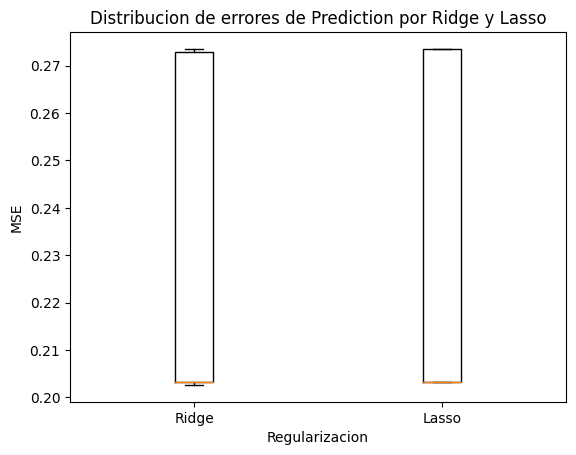

In [25]:
# creando el visualization, pero ahora no me parece correcto, y para ser honesto no me queda tan claro el segunda parte cuando visualizamos lambda

lambda_labels = [str(val) for val in rango_lambda]
print(len(lambda_labels))
print(len(mse_ridge_list))
print(len(mse_lasso_list))

# Subplots
fig, ax = plt.subplots()

# boxplots
ax.boxplot([mse_ridge_list, mse_lasso_list], labels=['Ridge', 'Lasso'])
ax.set_xticklabels(["Ridge", "Lasso"])
ax.set_xlabel("Regularizacion")
ax.set_ylabel("MSE")
ax.set_title("Distribucion de errores de Prediction por Ridge y Lasso")


. Elijan alguno de los modelos de regresio ́n log ́ıstica donde hayan probado distin- tos parametros de regularizacio ́n y comenten: ¿Qu ́e m ́etodo de regularizaci ́on funciono ́ mejor Ridge o LASSO? Comenten mencionando el error cuadra ́tico medio (ECM).

Segun de evalua_multiple_metodos, la penalidad de mi mejor_config era l1 (lasso), con un ECM de .2735

8. ¿Cu ́al de todos los m ́etodos evaluados predice mejor? ¿Con qu ́e hiperpara ́me- tros? Justifiquen detalladamente utilizando las medidas de precisi ́on que cono- cen.

Según de los resultados de evalua_multiple metodos, aparece que logistic_regression funcionó mejor, con el accuracy score basicamente igual a lda, y auc score basicamente igual de lda. aunque el confusion_matrix de lda produzcó uno mas predicíon verdadero, para mi prefiero regresión logistica, porque entiendo el funcionalidad de esta enfoque mejor.

9. Con el m ́etodo que seleccionaron, predigan qu ́e personas son pobres dentro de la base norespondieron. ¿Qu ́e proporci ́on de los hogares son pobres en esa submuestra?

In [60]:
norespondieron = merged_df[merged_df['ITF'] == 0].copy()
norespondieron['ingreso_necesario'] = norespondieron['ad_equiv_hogar1'] * canasta

percentile_20 = norespondieron['ingreso_necesario'].quantile(0.20)

# Definir pobre según de veinte percentile
norespondieron['pobre'] = (norespondieron['ingreso_necesario'] < percentile_20).astype(int) # se declara la columna pobreza


for column in norespondieron.columns: # hice lo mismo con respondieron
    try:
        norespondieron[column] = pd.to_numeric(norespondieron[column])
    except TypeError:
        norespondieron = norespondieron.drop([column], axis=1)
    except ValueError:
        norespondieron = norespondieron.drop([column], axis=1)

cuenta_pobreza = (norespondieron['pobre'] == 1).sum()
cuenta_todo = len(norespondieron)

# Calculate the proportion
proporción_pobreza = cuenta_pobreza / cuenta_todo
print('Propoción de hugares en pobreza: ', proporción_pobreza)

#20% en pobreza, y tiene sentido si tienes en cuenta lo que hice para clasificar pobreza de norespondieron (porque igual no me queda claro como clasificamos sin columnas de ingreso)




Propoción de hugares en pobreza:  0.20053715308863027


In [ ]:
norespondieron = norespondieron.drop(columns= ['adulto_equiv', 'ad_equiv_hogar1', 'ingreso_necesario'])
norespondieron = norespondieron.dropna()
y = norespondieron['pobre']
X = norespondieron.drop(columns = 'pobre')
X = norespondieron[['IV1', 'IV6', 'IV12_1', 'II9', 'V5', 'CH09', 'NIVEL_ED']]

# IV1 (tipo de alojamiento)
# IV6 (disponilidad de agua)
# IV12_1 (La vivienda está ubicada cerda de basural (3 cuadras o menos))
#II9 (Acceso de un Baño, propio baño, compartido con otras, etc))
# V5 (si han vivido de algún subsidio o ayuda social (de gobierno, iglesia, etc))
#CH09 - Sabe leer y escribir
#Nivel_ED - Nivel de educacción
X = X.copy()
X['intercept'] = 1
# declarar una columna con valores del intercept, cuando sea necessario




(1117, 8)
(1117,)
0       0
7       1
21      0
36      0
39      0
       ..
7259    0
7264    0
7267    0
7275    0
7283    0
Name: pobre, Length: 1117, dtype: int64


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mejor_config=evalua_config(X,y, k=5)


lr = LogisticRegression(penalty=mejor_config["penalidad"], C=1/mejor_config["alpha"], solver='liblinear')
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

l1
0.27357859531772577
Accuracy: 0.802675585284281
